In [6]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import os

from keras.models import Model, load_model
from keras.layers import Dense, LSTM, Input, Activation
from keras.optimizers import Adam

from sklearn.metrics import mean_squared_error
from utilities import *

2024-04-16 17:47:07.461601: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
class TradeAgent:
    def __init__(self, ticker, lookback = 30, features = 8):
        self.lookback = lookback
        self.features = features
        self.input_shape  = (lookback, features)
        self.action_size = 1 #predict scaled close difference
        self.stock = ticker
        
        self.model_exists = False
        if("model_" + ticker + "_" + str(lookback) + "lb.keras" in os.listdir('models')):
            filename = "models/model_"+ticker+"_"+str(lookback)+"lb.keras"
            self.model = load_model(filename)
            self.model_exists = True
        else:
            self.model = self._model()
            print("----------------------------------------------------------------Model Created----------------------------------------------------------------")
            
        # To be used for evaluation only
        self.X_test = None
        self.Y_test = None
    
    def _model(self):
        input_layer = Input(self.input_shape)
        lstm_layer = LSTM(150)(input_layer)
        # dense_layer = Dense(64, activation = 'linear')(lstm_layer)
        output_layer = Dense(1, activation = 'linear')(lstm_layer)
        model = Model(inputs = input_layer, outputs = output_layer)
        
        model.compile(optimizer = Adam(), loss = 'mse')
        model.summary()
        
        return model
    
    def train(self,  batch_size = 128, epochs = 100):
        if(not self.model_exists):
            X_train, Y_train, self.X_test, self.Y_test = preprocess(self.stock, self.lookback, self.features)
            # print(X_train.shape, Y_train.shape, self.Y_test.shape, self.X_test.shape)
            self.model.fit(x = X_train, 
                        y = Y_train, 
                        batch_size = batch_size, 
                        epochs = epochs, 
                        shuffle = True,
                        validation_split = 0.1)
            print("----------------------------------------------------------------Model Trained----------------------------------------------------------------")
        else:
            print("Model already trained.")
        
        
    def act(self, Y_test, true_val = True):
        if(true_val):
            return self.model.predict(Y_test)
        else:
            return inv_transform(self.model.predict(Y_test))
    
    def evaluate(self, graph = True):
        if not self.model_exists:
            print("Model doesn't exist or is not trained.")
            return None
        if(self.X_test is None):
            _, __, self.X_test, self.Y_test = preprocess(self.stock)
        y_pred = self.model.predict(self.X_test)
        mse = mean_squared_error(self.Y_test, y_pred)
        print("Test size: ", self.X_test.shape[0])
        print("Mean Squared Error: ", mse)
        
        if(graph):
            plt.figure(figsize=(16,8))
            plt.plot(self.Y_test, color = 'black', label = 'Test')
            plt.plot(y_pred, color = 'blue', label = 'pred')
            plt.legend()
            plt.show()
        return mse
    
    def save_model(self):
        if(not self.model_exists):
            filename = "models/model_" + self.stock + "_" + str(self.lookback) + "lb.keras"
            self.model.save(filename)
            print("Model saved successfully at", filename)
            self.model_exists = True

                

In [29]:
agent = TradeAgent('AAPL')

In [30]:
agent.train(32,30)

Model already trained.


In [31]:
agent.save_model()

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Test size:  2147
Mean Squared Error:  0.004455232195616714


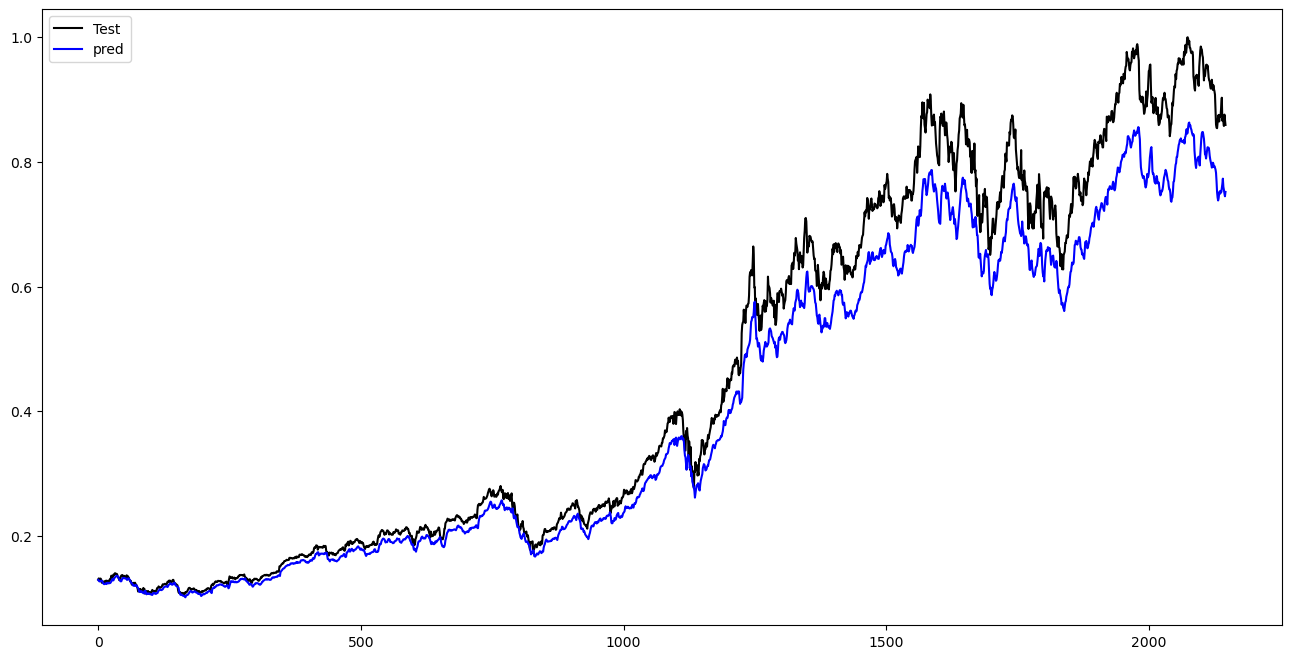

0.004455232195616714

In [6]:
agent.evaluate()